In [1]:
# pip install sodapy

In [2]:
# pip install us

In [3]:
import pandas as pd
from sodapy import Socrata
import requests as rq
import matplotlib.pyplot as plt
import us

In [77]:
# Enrollment data by state
# Source: https://www.kff.org/health-reform/state-indicator/medicaid-expansion-enrollment/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_medicaid = pd.read_csv('data/KFF_medicaid_enrollment.csv', header=2).loc[:51] # get rid of junk rows
df_medicaid = df_medicaid[~df_medicaid['Location'].isin(['United States', 'District of Columbia'])].reset_index()
df_medicaid = df_medicaid.rename(columns={
    'Location':'state',
    'Expanded by September 30th, 2022':'expanded_medicaid'
})
df_medicaid['expanded_medicaid'] = df_medicaid['expanded_medicaid'].replace({'Yes': True, 'No': False})
df_medicaid = df_medicaid[['state', 'expanded_medicaid']]

state_abbrs = []
for s in df_medicaid['state']:
    state_obj = us.states.lookup(s)
    state_abbrs.append(us.states.lookup(s).abbr)
df_medicaid['state_abbr'] = state_abbrs

df_medicaid.head()

,state,expanded_medicaid,state_abbr
0,Alabama,False,AL
1,Alaska,True,AK
2,Arizona,True,AZ
3,Arkansas,True,AR
4,California,True,CA


In [82]:
# ER data by state
# Source: https://www.kff.org/other/state-indicator/emergency-room-visits-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

df_er = pd.read_csv('data/KFF_ER_visits.csv', header=2).loc[:51] # get rid of junk rows
df_er = df_er[~df_er['Location'].isin(['United States', 'District of Columbia'])]
df_er = df_er.rename(columns={
    'Location':'state',
    'Total':'er_visits'
})
df_er = df_er.sort_values('er_visits', ascending=False).reset_index()
df_er = df_er.loc[:, ['state', 'er_visits']]

df_er.head()

,state,er_visits
0,Maine,596.0
1,Louisiana,535.0
2,Kentucky,525.0
3,West Virginia,524.0
4,Ohio,505.0


In [6]:
df_life_exp = pd.read_csv('data/cdc_life_exp.csv')
df_life_exp = df_life_exp.rename(columns={'STATE':'state_abbr', 'RATE':'life_exp'})

df_life_exp = df_life_exp.loc[df_life_exp['YEAR'] == max(df_life_exp['YEAR'])]
state_names = []
for s in df_life_exp['state_abbr']:
    state_names.append(us.states.lookup(s).name)
df_life_exp['state'] = state_names
df_life_exp = df_life_exp[['state', 'life_exp']]
df_life_exp = df_life_exp.sort_values('life_exp').reset_index().drop(columns='index')

df_life_exp.head()

,state,life_exp
0,Mississippi,71.9
1,West Virginia,72.8
2,Louisiana,73.1
3,Alabama,73.2
4,Kentucky,73.5


In [7]:
# API endpoint URL for poverty rate data by state
url = 'https://api.census.gov/data/timeseries/poverty/saipe?get=NAME,SAEPOVRTALL_PT&for=state:*&time=2021'

response = rq.get(url)
data = response.json()
cols = data[0]

df_poverty = pd.DataFrame(data[1:], columns=cols)
df_poverty = df_poverty.rename(columns={'NAME':'state',
                                        'SAEPOVRTALL_PT':'poverty_rate',
                                        'state':'state_num'})
df_poverty['poverty_rate'] = df_poverty['poverty_rate'].astype(float)
df_poverty = df_poverty.sort_values('poverty_rate', ascending=False).reset_index()[['state','poverty_rate']]

df_poverty.head()

,state,poverty_rate
0,Louisiana,19.5
1,Mississippi,19.2
2,New Mexico,17.7
3,District of Columbia,16.8
4,West Virginia,16.8


In [52]:
def make_plot(df, y_col, y_lbl, title):
    df = df.merge(df_medicaid, how='inner', on='state')
    
    plt.figure(figsize=(12, 3))
    plt.grid(True)
    for i in range(len(df)):
        if df.loc[i, 'expanded_medicaid']:
            plt.scatter(i, df[y_col][i], c='#30b5f2', marker='o', zorder=100)
        else:
            plt.scatter(i, df[y_col][i], c='#eb4034', marker='D', zorder=100)
    plt.xticks(range(len(df)), df['state_abbr'], rotation='horizontal', fontsize=8)

    plt.xlabel('State')
    plt.ylabel(y_lbl)
    plt.title(title)
    plt.axvline(x=len(df)/2, color='green', linestyle='-')
    plt.tick_params(axis='x', which='both', direction='in')
    plt.grid(True)
    plt.show()

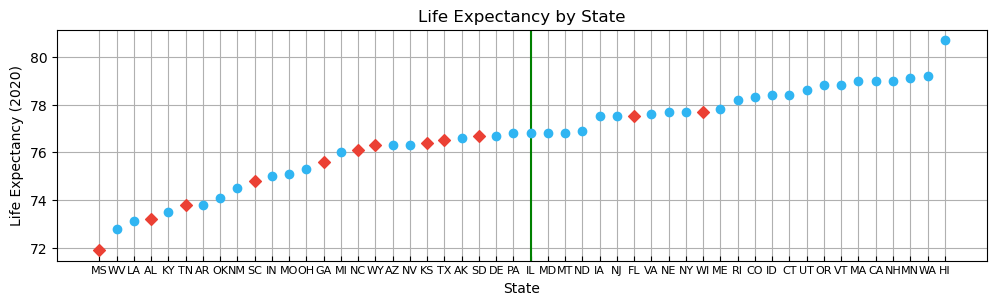

In [53]:
make_plot(df_life_exp, 'life_exp', 'Life Expectancy (2020)', 'Life Expectancy by State')

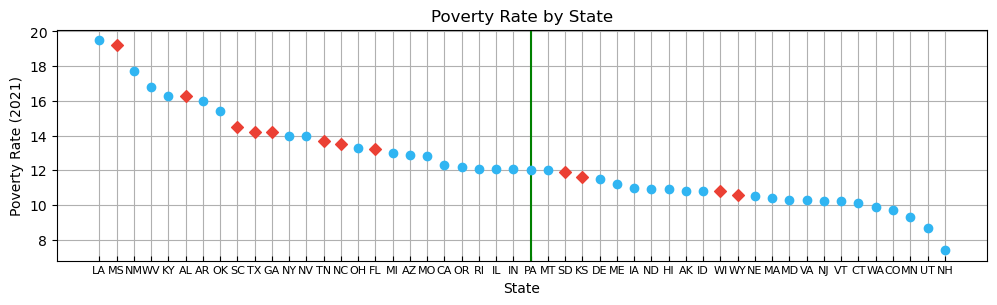

In [54]:
make_plot(df_poverty, 'poverty_rate', 'Poverty Rate (2021)', 'Poverty Rate by State')

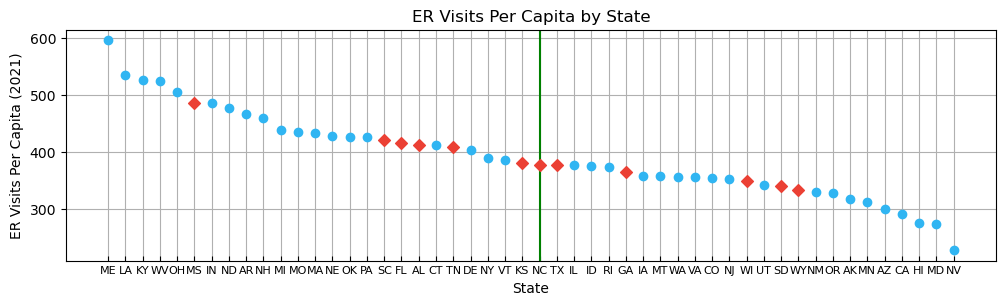

In [83]:
make_plot(df_er, 'er_visits', 'ER Visits Per Capita (2021)', 'ER Visits Per Capita by State')